# ENVI Tutorial

### What is COVET?

COVET is a method for representing and quantifying cellular niches based on their gene-gene covariance. COVET takes as input spatial data and returns the niche gene-gene covariance matrix of each cell.


### What is ENVI?
ENVI integrates between paired scRNA-seq and spatial data. ENVI relies on COVET and predicts spatial context of dissociated scRNA-seq data & imputes missing genes for the spatial data. ENVI takes as input spatial data and scRNA_seq data, trains a VAE model and produces latent embeddings for each dataset, imputed values for the spatial data, and predicted COVET matrices for the scRNA-seq data.


In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')


## Install ENVI

ENVI can be installed directly with pip with the following command:

In [2]:
!pip install scenvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.3/731.3 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 58.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:0

## Importing

In [3]:
import scenvi

E0000 00:00:1739897365.851503      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [4]:
!pip install fa2_modified 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 10.5 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install colorcet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.3/260.3 kB 8.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import colorcet
import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap
from fa2_modified import ForceAtlas2

## Utility Functions:

Some functions that are used in the analysis in this tutorial, feel free to switch to you own prefered versions

In [7]:
def flatten(arr):
    return(np.reshape(arr, [arr.shape[0], -1]))

def force_directed_layout(affinity_matrix, cell_names=None, verbose=True, iterations=500, device='cpu'):
    """" Function to compute force directed layout from the affinity_matrix
    :param affinity_matrix: Sparse matrix representing affinities between cells
    :param cell_names: pandas Series object with cell names
    :param verbose: Verbosity for force directed layout computation
    :param iterations: Number of iterations used by ForceAtlas 
    :return: Pandas data frame representing the force directed layout
    """

    init_coords = np.random.random((affinity_matrix.shape[0], 2))
    
    if device == 'cpu':
        forceatlas2 = ForceAtlas2(
            # Behavior alternatives
            outboundAttractionDistribution=False,  
            linLogMode=False,  
            adjustSizes=False,  
            edgeWeightInfluence=1.0,
            # Performance
            jitterTolerance=1.0,  
            barnesHutOptimize=True,
            barnesHutTheta=1.2,
            multiThreaded=False,  
            # Tuning
            scalingRatio=2.0,
            strongGravityMode=False,
            gravity=1.0,
            # Log
            verbose=verbose)

        positions = forceatlas2.forceatlas2(
            affinity_matrix, pos=init_coords, iterations=iterations)
        positions = np.array(positions)
        
        
    positions = pd.DataFrame(positions,
                             index=np.arange(affinity_matrix.shape[0]), columns=['x', 'y'])
    return positions

def run_diffusion_maps(data_df, n_components=10, knn=30, alpha=0):
    """Run Diffusion maps using the adaptive anisotropic kernel
    :param data_df: PCA projections of the data or adjacency matrix
    :param n_components: Number of diffusion components
    :param knn: Number of nearest neighbors for graph construction
    :param alpha: Normalization parameter for the diffusion operator
    :return: Diffusion components, corresponding eigen values and the diffusion operator
    """
    
    # Determine the kernel
    N = data_df.shape[0]

    if(type(data_df).__module__ == np.__name__):
        data_df = pd.DataFrame(data_df)
    
    if not scipy.sparse.issparse(data_df):
        print("Determing nearest neighbor graph...")
        temp = sc.AnnData(data_df.values)
        sc.pp.neighbors(temp, n_pcs=0, n_neighbors=knn)
        kNN = temp.obsp['distances']

        # Adaptive k
        adaptive_k = int(np.floor(knn / 3))
        adaptive_std = np.zeros(N)

        for i in np.arange(len(adaptive_std)):
            adaptive_std[i] = np.sort(kNN.data[kNN.indptr[i] : kNN.indptr[i + 1]])[
                adaptive_k - 1
            ]

        # Kernel
        x, y, dists = scipy.sparse.find(kNN)

        # X, y specific stds
        dists = dists / adaptive_std[x]
        W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])

        # Diffusion components
        kernel = W + W.T
    else:
        kernel = data_df

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    if alpha > 0:
        # L_alpha
        D[D != 0] = D[D != 0] ** (-alpha)
        mat = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N])
        kernel = mat.dot(kernel).dot(mat)
        D = np.ravel(kernel.sum(axis=1))

    D[D != 0] = 1 / D[D != 0]
    T = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigen value dcomposition
    D, V = scipy.sparse.linalg.eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Create are results dictionary
    res = {"T": T, "EigenVectors": V, "EigenValues": D}
    res["EigenVectors"] = pd.DataFrame(res["EigenVectors"])
    if not scipy.sparse.issparse(data_df):
        res["EigenVectors"].index = data_df.index
    res["EigenValues"] = pd.Series(res["EigenValues"])
    res["kernel"] = kernel

    return res


def FDL(data, k = 30):
    

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=int(k), metric='euclidean',
                               n_jobs=5).fit(data)
    kNN = nbrs.kneighbors_graph(data, mode='distance')
    # Adaptive k
    
    adaptive_k = int(np.floor(k / 3))
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=int(adaptive_k),
                           metric='euclidean', n_jobs=5).fit(data)
    adaptive_std = nbrs.kneighbors_graph(data, mode='distance').max(axis=1)
    adaptive_std = np.ravel(adaptive_std.todense())
    # Kernel
    x, y, dists = scipy.sparse.find(kNN)
    # X, y specific stds
    dists = dists / adaptive_std[x]
    N = data.shape[0]
    W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])
    # Diffusion components
    kernel = W + W.T
    layout = force_directed_layout(kernel)
    return(layout)


## Data

Downloading Motor Cortex scRNA-seq and MERFISH data from the Pe'er lab aws and loading in with scanpy

In [8]:
import tensorflow as tf

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    tf.tpu.experimental.initialize_tpu_system(tpu)  # Runs only once!
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
    print("✅ TPU successfully initialized!")
except ValueError:
    print("⚠️ TPU was already initialized. Continuing...")


⚠️ TPU was already initialized. Continuing...


In [10]:
st_data = sc.read_h5ad('/kaggle/input/merfish-data/st_data.h5ad')
sc_data = sc.read_h5ad('/kaggle/input/merfish-data/sc_data.h5ad')

Defining cell type color palette

In [11]:
cell_type_palette = {'Astro': (0.843137, 0.0, 0.0, 1.0),
                     'Endo': (0.54902, 0.235294, 1.0, 1.0),
                     'L23_IT': (0.007843, 0.533333, 0.0, 1.0),
                     'L45_IT': (0.0, 0.67451, 0.780392, 1.0),
                     'L56_NP': (0.596078, 1.0, 0.0, 1.0),
                     'L5_ET': (1.0, 0.498039, 0.819608, 1.0),
                     'L5_IT': (0.423529, 0.0, 0.309804, 1.0),
                     'L5_PT': (1.0, 0.647059, 0.188235, 1.0),
                     'L6_CT': (0.345098, 0.231373, 0.0, 1.0),
                     'L6_IT': (0.0, 0.341176, 0.34902, 1.0),
                     'L6_IT_Car3': (0.0, 0.0, 0.866667, 1.0),
                     'L6b': (0.0, 0.992157, 0.811765, 1.0),
                     'Lamp5': (0.631373, 0.458824, 0.415686, 1.0),
                     'Microglia': (0.737255, 0.717647, 1.0, 1.0),
                     'OPC': (0.584314, 0.709804, 0.470588, 1.0),
                     'Oligo': (0.752941, 0.015686, 0.72549, 1.0),
                     'Pericytes': (0.392157, 0.329412, 0.454902, 1.0),
                     'Pvalb': (0.47451, 0.0, 0.0, 1.0),
                     'SMC': (0.027451, 0.454902, 0.847059, 1.0),
                     'Sncg': (0.996078, 0.960784, 0.564706, 1.0),
                     'Sst': (0.0, 0.294118, 0.0, 1.0),
                     'VLMC': (0.560784, 0.478431, 0.0, 1.0),
                     'Vip': (1.0, 0.447059, 0.4, 1.0)}

cell_label_palette = {'GABAergic': (0.843137, 0.0, 0.0, 1.0),
                      'Glutamatergic': (0.54902, 0.235294, 1.0, 1.0),
                      'Non-Neuronal': (0.007843, 0.533333, 0.0, 1.0)}

### Plotting the Motor Cortex MERFISH 

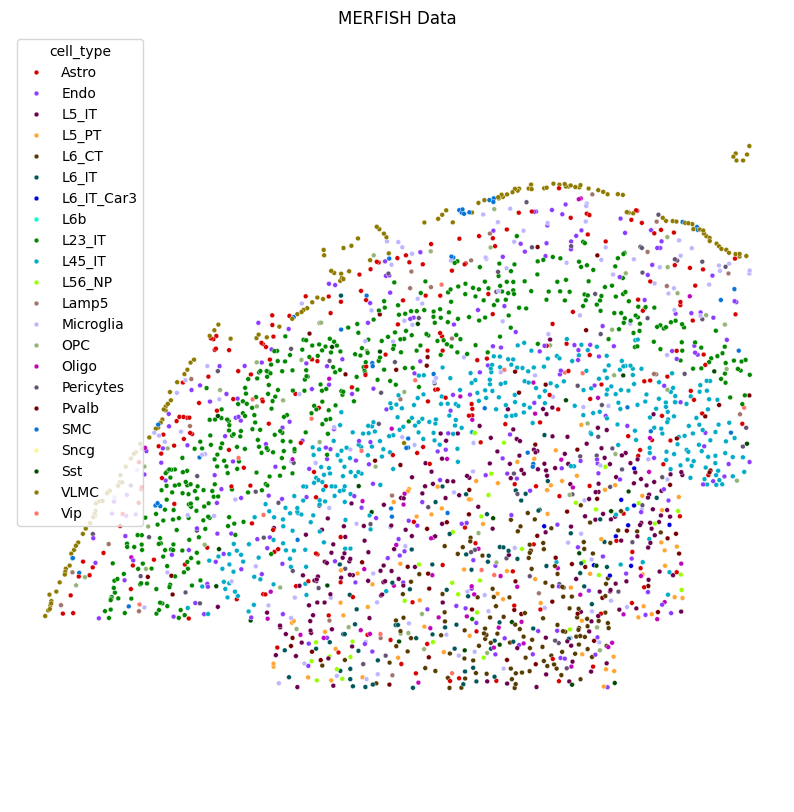

In [12]:
plt.figure(figsize=(10,10))

sns.scatterplot(x = st_data.obsm['spatial'][st_data.obs['batch'] == 'mouse1_slice10'][:, 1], 
                y = -st_data.obsm['spatial'][st_data.obs['batch'] == 'mouse1_slice10'][:, 0], legend = True,
                hue = st_data.obs['cell_type'][st_data.obs['batch'] == 'mouse1_slice10'], 
                s = 12, palette = cell_type_palette)
plt.axis('equal')
plt.axis('off')
plt.title("MERFISH Data")
plt.show()

### Plotting the Motor Cortex scRNAseq

In [13]:
fit = umap.UMAP(
    n_neighbors = 100,
    min_dist = 0.8,
    n_components = 2,
)

sc_data.layers['log'] = np.log(sc_data.X + 1)
sc.pp.highly_variable_genes(sc_data, layer = 'log', n_top_genes = 2048)
sc_data.obsm['UMAP_exp'] = fit.fit_transform(np.log(sc_data[:, sc_data.var['highly_variable']].X + 1))

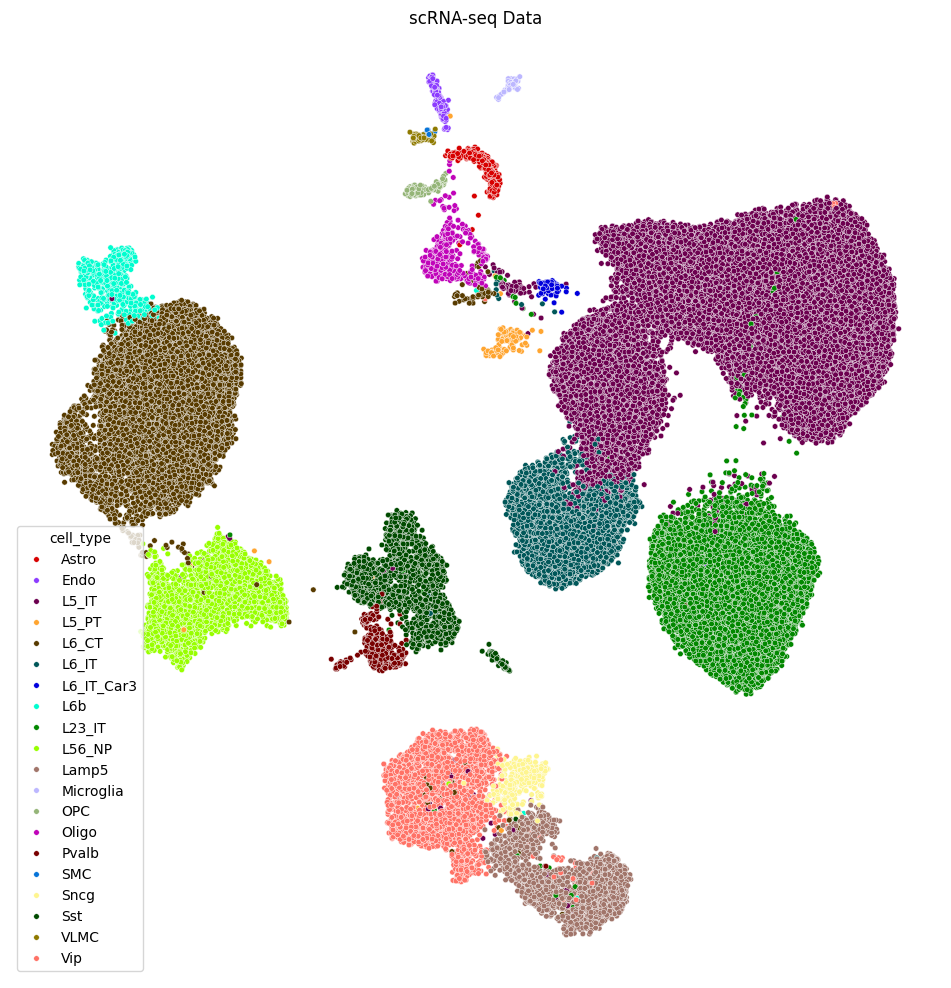

In [14]:
fig = plt.figure(figsize = (10,10))
sns.scatterplot(x = sc_data.obsm['UMAP_exp'][:, 0], y = sc_data.obsm['UMAP_exp'][:, 1],  hue = sc_data.obs['cell_type'], s = 16,
                palette = cell_type_palette, legend = True)
plt.tight_layout()
plt.axis('off')
plt.title('scRNA-seq Data')
plt.show()

## Running ENVI

We first define and ENVI model which computes the COVET matrices of the spatial data and intializes the CVAE:

In [17]:
envi_model = scenvi.ENVI(spatial_data = st_data, sc_data = sc_data)


DEBUG
Computing Niche Covariance Matrices
Initializing CVAE
Finished Initializing ENVI


In [18]:
envi_model.train()
envi_model.impute_genes()
envi_model.infer_niche_covet()
envi_model.infer_niche_celltype()

 spatial: -6.473e-01 sc: -7.471e-01 cov: -5.486e-03 kl: 6.639e-01: 100%|██████████| 16000/16000 [04:23<00:00, 60.75it/s]


Finished imputing missing gene for spatial data! See 'imputation' in obsm of ENVI.spatial_data


In [20]:
st_data.obsm['envi_latent'] = envi_model.spatial_data.obsm['envi_latent']
st_data.obsm['COVET'] = envi_model.spatial_data.obsm['COVET']
st_data.obsm['COVET_SQRT'] = envi_model.spatial_data.obsm['COVET_SQRT']
st_data.uns['COVET_genes'] =  envi_model.CovGenes
st_data.obsm['imputation'] = envi_model.spatial_data.obsm['imputation']
st_data.obsm['cell_type_niche'] = envi_model.spatial_data.obsm['cell_type_niche']

sc_data.obsm['envi_latent'] = envi_model.sc_data.obsm['envi_latent']
sc_data.obsm['COVET'] = envi_model.sc_data.obsm['COVET']
sc_data.obsm['COVET_SQRT'] = envi_model.sc_data.obsm['COVET_SQRT']
sc_data.obsm['cell_type_niche'] = envi_model.sc_data.obsm['cell_type_niche']
sc_data.uns['COVET_genes'] =  envi_model.CovGenes

In [21]:
# Save spatial data
np.savez("st_data_ndarray.npz",
         envi_latent=st_data.obsm['envi_latent'],
         COVET=st_data.obsm['COVET'],
         COVET_SQRT=st_data.obsm['COVET_SQRT'],
         COVET_genes=st_data.uns['COVET_genes'],
         imputation=st_data.obsm['imputation'],
         cell_type_niche=st_data.obsm['cell_type_niche'])

# Save single-cell data
np.savez("sc_data_ndarray.npz",
         envi_latent=sc_data.obsm['envi_latent'],
         COVET=sc_data.obsm['COVET'],
         COVET_SQRT=sc_data.obsm['COVET_SQRT'],
         cell_type_niche=sc_data.obsm['cell_type_niche'],
         COVET_genes=sc_data.uns['COVET_genes'])

Training ENVI and run auxiliary function

Read ENVI predictions

### Plot UMAPs of ENVI latent

Double Checking that cell types co-embed from the MERFISH and scRNA-seq datasets

In [ ]:
fit = umap.UMAP(
    n_neighbors = 100,
    min_dist = 0.3,
    n_components = 2,
)

latent_umap = fit.fit_transform(np.concatenate([st_data.obsm['envi_latent'], sc_data.obsm['envi_latent']], axis = 0))

st_data.obsm['latent_umap'] = latent_umap[:st_data.shape[0]]
sc_data.obsm['latent_umap'] = latent_umap[st_data.shape[0]:]

In [ ]:

lim_arr = np.concatenate([st_data.obsm['latent_umap'], sc_data.obsm['latent_umap']], axis = 0)


delta = 1
pre = 0.1
xmin = np.percentile(lim_arr[:, 0], pre) - delta 
xmax = np.percentile(lim_arr[:, 0], 100 - pre) + delta
ymin = np.percentile(lim_arr[:, 1], pre) - delta 
ymax = np.percentile(lim_arr[:, 1], 100 - pre) + delta


In [ ]:
fig = plt.figure(figsize = (13,5))
plt.subplot(121)
sns.scatterplot(x = sc_data.obsm['latent_umap'][:, 0], 
                y = sc_data.obsm['latent_umap'][:, 1], hue = sc_data.obs['cell_type'], s = 8, palette = cell_type_palette, 
                legend = False)
plt.title("scRNA-seq Latent")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis('off')

plt.subplot(122)
sns.scatterplot(x = st_data.obsm['latent_umap'][:, 0], 
                y = st_data.obsm['latent_umap'][:, 1],  hue = st_data.obs['cell_type'], s = 8, palette = cell_type_palette, legend = True)


legend = plt.legend(title = 'Cell Type', prop={'size': 12}, fontsize = '12',  markerscale = 3, ncol = 2, bbox_to_anchor = (1, 1))#, loc = 'lower left')
plt.setp(legend.get_title(),fontsize='12')
plt.title("MERFISH Latent")
plt.axis('off')
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

# UMAP FOR COVET SQRT

In [ ]:
print("Shape of st_data.obsm['COVET_SQRT']:", st_data.obsm['COVET_SQRT'].shape)
print("Shape of sc_data.obsm['COVET_SQRT']:", sc_data.obsm['COVET_SQRT'].shape)


## ENVI COVET analysis

- Zooming on the Glutamatergic neuron, and using their COVET embedding for pseudo-depth prediction

In [ ]:
st_data_sst = st_data[st_data.obs['cell_type'] == 'Sst']
sc_data_sst = sc_data[sc_data.obs['cell_type'] == 'Sst']

In [ ]:
gran_sst_palette = {'Th': (0.0, 0.294118, 0.0, 1.0),
                    'Calb2': (0.560784, 0.478431, 0.0, 1.0),
                    'Chodl': (1.0, 0.447059, 0.4, 1.0),
                    'Myh8': (0.933333, 0.72549, 0.72549, 1.0),
                    'Crhr2': (0.368627, 0.494118, 0.4, 1.0),
                    'Hpse': (0.65098, 0.482353, 0.72549, 1.0),
                    'Hspe': (0.352941, 0.0, 0.643137, 1.0),
                    'Crh': (0.607843, 0.894118, 1.0, 1.0),
                    'Pvalb Etv1': (0.92549, 0.0, 0.466667, 1.0)}

### Calculating FDL and DC on COVET

- Note that we are running FDL on COVET_SQRT, this is because the distance between COVET matrices is the L2 between their SQRT. We can simply run FDL (or DC, UMAP, PhenoGraph, etc.) on the COVET_SQRT to analyize COVET niche representation!

In [ ]:

FDL_COVET = np.asarray(FDL(np.concatenate([flatten(st_data_sst.obsm['COVET_SQRT']), 
                                           flatten(sc_data_sst.obsm['COVET_SQRT'])], axis = 0), k = 30))

st_data_sst.obsm['FDL_COVET'] = FDL_COVET[:st_data_sst.shape[0]]
sc_data_sst.obsm['FDL_COVET'] = FDL_COVET[st_data_sst.shape[0]:]

In [ ]:
DC_COVET = np.asarray(run_diffusion_maps(np.concatenate([flatten(st_data_sst.obsm['COVET_SQRT']), 
                                                         flatten(sc_data_sst.obsm['COVET_SQRT'])], axis = 0), knn = 30)['EigenVectors'])[:, 1:]
st_data_sst.obsm['DC_COVET'] = -DC_COVET[:st_data_sst.shape[0]]
sc_data_sst.obsm['DC_COVET'] = -DC_COVET[st_data_sst.shape[0]:]

### Reverse DC if needed

- DC direction is arbitrary; so flip DC direction if it's backwards
- Should go from blue (shallow) to green (deep)

In [ ]:
st_data_sst.obsm['DC_COVET'] = -DC_COVET[:st_data_sst.shape[0]]
sc_data_sst.obsm['DC_COVET'] = -DC_COVET[st_data_sst.shape[0]:]

### Plot DC and Depth

In [ ]:
lim_arr = np.concatenate([st_data_sst.obsm['FDL_COVET'], sc_data_sst.obsm['FDL_COVET']], axis = 0)


delta = 1000
pre = 0.01
xmin = np.percentile(lim_arr[:, 0], pre) - delta 
xmax = np.percentile(lim_arr[:, 0], 100 - pre) + delta
ymin = np.percentile(lim_arr[:, 1], pre) - delta 
ymax = np.percentile(lim_arr[:, 1], 100 - pre) + delta

In [ ]:



plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x = sc_data_sst.obsm['FDL_COVET'][:, 0], 
                y = sc_data_sst.obsm['FDL_COVET'][:, 1],  
                hue = sc_data_sst.obs['cluster_label'], s = 16,  palette= gran_sst_palette, legend = True)
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.title('scRNA-seq Sst, COVET FDL')
legend = plt.legend(title = 'Sst subtype', prop={'size': 8}, fontsize = '8',  markerscale = 1, ncol = 2)
plt.axis('off')

plt.subplot(122)
ax = sns.scatterplot(x = st_data_sst.obsm['FDL_COVET'][:, 0], 
                y = st_data_sst.obsm['FDL_COVET'][:, 1],  
                c = st_data_sst.obsm['DC_COVET'][:,0], s = 16,  cmap= 'cet_CET_D13', legend = False)
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis('off')
plt.title('MERFISH Sst, COVET FDL')
plt.show()

In [ ]:
fig = plt.figure(figsize=(25,5))

for ind, batch in enumerate(['mouse1_slice212', 'mouse1_slice162', 'mouse1_slice71', 'mouse2_slice270', 'mouse1_slice40']):
    st_dataBatch = st_data[st_data.obs['batch'] == batch]
    st_dataPlotBatch = st_data_sst[st_data_sst.obs['batch'] == batch]
    
    plt.subplot(1,5, 1+ ind)
    sns.scatterplot(x = st_dataBatch.obsm['spatial'][:, 0], y = st_dataBatch.obsm['spatial'][:, 1],  color = (207/255,185/255,151/255, 1))
    sns.scatterplot(x = st_dataPlotBatch.obsm['spatial'][:, 0], y = st_dataPlotBatch.obsm['spatial'][:, 1], marker = '^',
                        c = st_dataPlotBatch.obsm['DC_COVET'][:, 0], s = 256,  cmap= 'cet_CET_D13', legend = False)
    plt.title(batch)
    plt.axis('off')
    plt.tight_layout()
    
plt.show()

## Subtype Depth

- Box plot of cortical depth for each cell in every subtype

In [ ]:
depth_df = pd.DataFrame()
depth_df['Subtype'] = sc_data_sst.obs['cluster_label']
depth_df['Depth'] = -sc_data_sst.obsm['DC_COVET'][:,0]

In [ ]:
subtype_depth_order = depth_df.groupby(['Subtype']).mean().sort_values(by = 'Depth', ascending=False).index

In [ ]:
plt.figure(figsize=(12,5))
sns.set(font_scale=1.7) 
sns.set_style("whitegrid")
sns.boxenplot(depth_df, x = 'Subtype', y = 'Depth',# bw = 1, width = 0.9,
          order = subtype_depth_order, 
          palette = gran_sst_palette)
plt.tight_layout()
plt.show()

## Niche Cell Type Composition

In [ ]:
subtype_canonical = pd.DataFrame([sc_data_sst[sc_data_sst.obs['cluster_label']==subtype].obsm['cell_type_niche'].mean(axis = 0) for subtype in subtype_depth_order],
                                     index = subtype_depth_order, columns = sc_data.obsm['cell_type_niche'].columns)

In [ ]:
subtype_canonical[subtype_canonical<0.2] = 0
subtype_canonical.drop(labels=subtype_canonical.columns[(subtype_canonical == 0).all()], axis=1, inplace=True)
subtype_canonical = subtype_canonical.div(subtype_canonical.sum(axis=1), axis=0)

### Plot as Stacked Bar Plots

In [ ]:
subtype_canonical.plot(kind = 'bar', stacked = 'True', 
                       color = {col:cell_type_palette[col] for col in subtype_canonical.columns})
plt.legend(bbox_to_anchor = (1,1), ncols = 1, fontsize = 'x-small')
plt.title("Predicted Niche Composition")
plt.ylabel("Proportion")
plt.xlabel("Sst Subtype")
plt.show()

## ENVI imputation on Spatial Data

In [ ]:
tick_genes = np.asarray(['Adamts18','Pamr1', 'Dkkl1', 'Hs6st2', 'Slit1', 'Ighm'])

In [ ]:
plt.figure(figsize=(15,10))

for ind, gene in enumerate(tick_genes):
    plt.subplot(2,3,1+ind)
    
    cvec = np.log(st_data[st_data.obs['batch'] == 'mouse1_slice10'].obsm['imputation'][gene] + 0.1)
    sns.scatterplot(x = st_data.obsm['spatial'][st_data.obs['batch'] == 'mouse1_slice10'][:, 1], 
                    y = -st_data.obsm['spatial'][st_data.obs['batch'] == 'mouse1_slice10'][:, 0], legend = False,
                    c = cvec, cmap = 'Reds',
                    vmax = np.percentile(cvec, 95), vmin = np.percentile(cvec, 30),
                    s = 24, edgecolor = 'k')#, palette = cell_type_palette)
    plt.title(gene)
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
plt.show()

## CALCULATING SNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

class SimilarityComputation:
    def __init__(self, envi_latent, covet_sqrt, k=5):
        """
        Initializes the similarity computation with ENVI latent and COVET_SQRT representations.
        
        :param envi_latent: np.ndarray, latent representations from ENVI
        :param covet_sqrt: np.ndarray, square root transformed COVET data
        :param k: int, number of nearest neighbors
        """
        self.envi_latent = envi_latent
        self.covet_sqrt = covet_sqrt
        self.k = k
        self.covet_sqrt_flattened = None
    
    def flatten_covet(self):
        """Flattens the COVET_SQRT matrix if it has more than 2 dimensions."""
        if self.covet_sqrt.ndim > 2:
            self.covet_sqrt_flattened = self.covet_sqrt.reshape(self.covet_sqrt.shape[0], -1)
        else:
            self.covet_sqrt_flattened = self.covet_sqrt
    
    def compute_knn_indices(self, data):
        """Computes K-nearest neighbors (KNN) indices for the given data."""
        knn = NearestNeighbors(n_neighbors=self.k, metric='cosine').fit(data)
        _, indices = knn.kneighbors(data)
        return indices
    
    def compute_snn(self, knn_indices):
        """Computes shared nearest neighbors (SNN) similarity matrix based on KNN indices."""
        n_samples = knn_indices.shape[0]
        snn_matrix = np.zeros((n_samples, n_samples))
        
        for i in range(n_samples):
            for j in range(n_samples):
                if i != j:
                    shared_neighbors = len(set(knn_indices[i]) & set(knn_indices[j]))
                    snn_matrix[i, j] = shared_neighbors / self.k
        
        return snn_matrix
    
    def compute_snn_for_sc_data(self):
        """Computes SNN for ENVI latent representations."""
        knn_indices = self.compute_knn_indices(self.envi_latent)
        return self.compute_snn(knn_indices)
    
    def compute_snn_for_covet(self):
        """Computes SNN for COVET_SQRT representations."""
        if self.covet_sqrt_flattened is None:
            self.flatten_covet()
        knn_indices = self.compute_knn_indices(self.covet_sqrt_flattened)
        return self.compute_snn(knn_indices)
    
    def compute_final_snn(self):
        """Computes the final similarity matrix by combining SNN from ENVI and COVET."""
        snn_sc = self.compute_snn_for_sc_data()
        snn_covet = self.compute_snn_for_covet()
        
        snn_combined = (snn_sc + snn_covet) / 2.0
        return np.nan_to_num(snn_combined)
    




In [ ]:
envi_latent = st_data.obsm['envi_latent'] 
covet_sqrt = st_data.obsm['COVET_SQRT']  

similarity_computer = SimilarityComputation(envi_latent, covet_sqrt, k=5)
final_snn_matrix = similarity_computer.compute_final_snn()
print(final_snn_matrix)